# Housing Peices Using Regression Models (Supervised Machine Learning)

## 1.Import the Libraries

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.datasets import make_regression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_regression, RFECV, SelectFromModel
from sklearn import set_config
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error


## 2.Housing Prices Dataset

In [ ]:
url = "https://drive.google.com/file/d/1HYOKYj_soE2NNHFYGxI-OtPWCmgU0O0M/view?usp=sharing"
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
house = pd.read_csv(path)

### 2.1 Exploration

In [ ]:
house.info()

In [ ]:
house.columns

In [ ]:
#house['SalePrice']

In [ ]:
house = house.drop("Id", axis=1)

### 2.2 X & Y Creation

In [ ]:
X = house.copy()
y = X.pop("SalePrice")

In [ ]:
#y

### 2.3 Train,Test & Split the Data

In [ ]:
# Split the data into training and test sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
#y_train

## 3.Preprocessor

In [ ]:
from sklearn.impute import KNNImputer
from sklearn.pipeline import make_pipeline

# 0. Set the config so that we can view our preprocessor
set_config(display="diagram")

# 1. defining categorical & ordinal columns
X_cat = X.select_dtypes(exclude="number").copy()
X_num = X.select_dtypes(include="number").copy()

# 2. numerical pipeline
numeric_pipe = make_pipeline(
    SimpleImputer(strategy="mean"))

#categorical pipeline
categoric_pipe = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="N_A"),
    OneHotEncoder(sparse_output=False,handle_unknown="ignore")
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num_pipe", numeric_pipe, X_num.columns),
        ("cat_pipe", categoric_pipe, X_cat.columns),
    ]
)

preprocessor

ColumnTransformer(transformers=[('num_pipe',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer())]),
                                 Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',...
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object'))])

## 4.Modelling

### 4.1 Dummy Model (LotArea Feature)

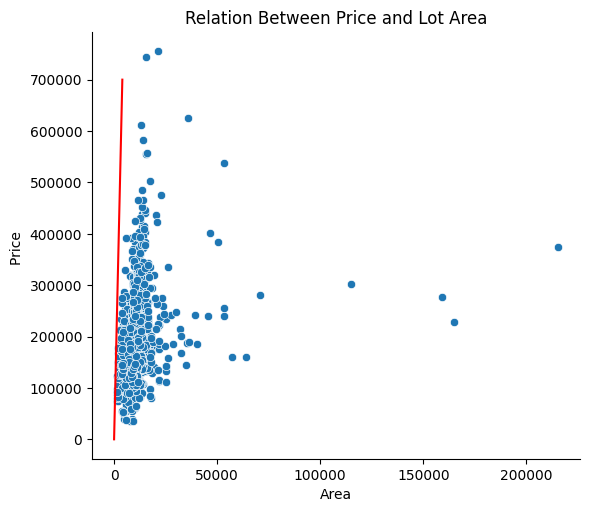

In [ ]:
## dummy model
import seaborn as sns
import matplotlib.pyplot as plt

(
  sns.relplot(data=house,
              x='LotArea',
              y='SalePrice',
              height=5,
              aspect=1.2)
  .set(title='Relation Between Price and Lot Area')
  .set_axis_labels('Area', 'Price ')
)

plt.plot([0, 4000], [0, 700000], 'r-')
plt.show();

In [ ]:
def dummy_model(TotalBsmtSF):
    return TotalBsmtSF *1000

In [ ]:
# predictions for the test set using our dummy model.

dummy_y_test_pred = dummy_model(X_test['LotArea'])
dummy_y_test_pred

892      8414000
1105    12256000
413      8960000
522      5000000
1036    12898000
          ...   
479      5925000
1361    16158000
802      8199000
651      9084000
722      8120000
Name: LotArea, Length: 292, dtype: int64

In [ ]:
# predictions for the train set using our dummy model.

dummy_y_train_pred = dummy_model(X_train['LotArea'])
dummy_y_train_pred

In [ ]:
from sklearn.metrics import mean_absolute_error
dummy_mae = mean_absolute_error(y_true = y_test,
                               y_pred = dummy_y_test_pred)
dummy_mae

9646732.106164383

In [ ]:
dummy_rmse = mean_squared_error(y_true = y_test,
                               y_pred = dummy_y_test_pred,
                               squared=False)
dummy_rmse

11281811.377666147

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error

dummy_mape = mean_absolute_percentage_error(y_true = y_test,
                                           y_pred = dummy_y_test_pred)
dummy_mape

60.81267759782634

In [ ]:
# Calculate R-squared score for test sets
from sklearn.metrics import r2_score

dummy_r2 = r2_score(y_true = y_test,
                   y_pred = dummy_y_test_pred)

dummy_r2

-16592.722942575267

In [ ]:
# Calculate R-squared score for train sets
dummy_train = r2_score(y_true = y_train,
                   y_pred = dummy_y_train_pred)

dummy_train

-37831.00120279138

In [ ]:
dummy_mae, dummy_rmse, dummy_mape, dummy_r2, dummy_train

(9646732.106164383,
 11281811.377666147,
 60.81267759782634,
 -16592.722942575267,
 -37831.00120279138)

### 4.2 DecisionTree Regressor

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

#Decision Tree Base Pipeline
dtbase_full_pipeline = make_pipeline(preprocessor,
                                  StandardScaler(),
                                  DecisionTreeRegressor())

dtbase_param_grid = {
    "columntransformer__num_pipe__simpleimputer__strategy": ["mean", "median"],
    "decisiontreeregressor__max_depth": range(2,14,2),
    "decisiontreeregressor__min_samples_split": range(3, 12, 2),
    "decisiontreeregressor__min_samples_leaf": range(1, 5),
    "decisiontreeregressor__max_features": ["sqrt", "log2"]
}
# GridSearchCV for Decision Tree Base model
dtbase_search = GridSearchCV(dtbase_full_pipeline,
                             dtbase_param_grid,
                             cv=5,
                             n_jobs= -1,
                             verbose=1)

In [ ]:
dtbase_search.fit(X_train, y_train)

In [ ]:
# Predictions on training and test sets
y_train_pred = dtbase_search.predict(X_train)
y_test_pred = dtbase_search.predict(X_test)

In [ ]:
#y_test_pred

In [ ]:
# Calculate root mean squared errors for test sets

dt_rmse = mean_squared_error(y_true = y_test,
                               y_pred = y_test_pred,
                               squared=False)
dt_rmse

48949.45356637455

In [ ]:
# Calculate R-squared score for test sets

dt_r2 = r2_score(y_true = y_test,
                   y_pred = y_test_pred)

dt_r2

0.6876209772927844

In [ ]:
# Calculate R-squared score for train sets

dt_train = r2_score(y_true = y_train,
                   y_pred = y_train_pred)

dt_train

0.8351024573995279

In [ ]:
pd.DataFrame({"test": [dummy_r2, dt_r2],"train": [dummy_train, dt_train]},
             index=["dummy_model", "decision_tree",])

,test,train
dummy_model,-16592.722943,-37831.001203
decision_tree,0.687621,0.835102


### 4.3 Linear Regressor

In [ ]:
## LinearRegression
full_pipelineLR = make_pipeline(preprocessor,
                            StandardScaler(),
                            LinearRegression())

param_gridLR = {
    "columntransformer__num_pipe__simpleimputer__strategy":["mean", "median"],
    "linearregression__fit_intercept": [True, False]

}

searchLR = GridSearchCV(full_pipelineLR,
                      param_gridLR,
                      cv=5,
                      n_jobs = -1,
                      verbose=1)


# Fit the data to the model
searchLR.fit(X_train, y_train)

In [ ]:
# Calculate R-squared score for test sets
LR_predictions = searchLR.predict(X_test)

lr_r2 = r2_score(y_true = y_test,
                 y_pred = LR_predictions)
lr_r2

-1.9569333453313827e+23

In [ ]:
# Calculate R-squared score for train sets
LR_predictions_train = searchLR.predict(X_train)
LR_train = r2_score(y_true = y_train,
                   y_pred = LR_predictions_train)

LR_train

0.9400512490845575

In [ ]:
pd.DataFrame({"test": [dummy_r2, dt_r2,lr_r2],"train": [dummy_train, dt_train,LR_train]},
             index=["dummy_model", "decision_tree","Linear Regression"	])

,test,train
dummy_model,-1.659272e+04,-37831.001203
decision_tree,6.876210e-01,0.835102
Linear Regression,-1.956933e+23,0.940051


### 4.4 SGD Regressor


In [ ]:
# SGDRegressor
SGD_pipeline = make_pipeline(preprocessor,
                            StandardScaler(),
                            SGDRegressor())

param_gridSGD = {
    "columntransformer__num_pipe__simpleimputer__strategy":["mean", "median"],
    "sgdregressor__fit_intercept": [True, False]

}

SGDsearch = GridSearchCV(SGD_pipeline,
                      param_gridSGD,
                      cv=5,
                      n_jobs = -1,
                      verbose=1)



# Fit the data to the model
SGDsearch.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('num_pipe',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer())]),
                                                                         Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'Lo...
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object'))])),
                                       ('standardscaler', StandardScaler()),
                                       ('sgdregressor', SGDRegressor())]),
             n_jobs=-1,
             param_grid={'columntransformer__num_pipe__simpleimputer__strategy': ['mean',
                                                                                  'median'],
                         'sgdregressor__fit_intercept': [True, False]},
             verbose=1)

In [ ]:
# Calculate R-squared score for test sets
SGD_predictions = SGDsearch.predict(X_test)

SGD_r2 = r2_score(y_true = y_test,
                 y_pred = SGD_predictions)
SGD_r2

-72.89880357000516

In [ ]:
# Calculate R-squared score for train sets
SGD_predictions_train = SGDsearch.predict(X_train)

SGD_tr = r2_score(y_true = y_train,
                     y_pred = SGD_predictions_train)

SGD_tr

-4559.149946198411

In [ ]:
pd.DataFrame({"test": [dummy_r2, dt_r2,lr_r2,SGD_r2],"train": [dummy_train, dt_train,LR_train,SGD_train ]},
             index=["dummy_model", "decision_tree","Linear Regression","SGD Regreesor"	])

,test,train
dummy_model,-1.659272e+04,-37831.001203
decision_tree,6.876210e-01,0.835102
Linear Regression,-1.956933e+23,0.940051
SGD Regreesor,-7.289880e+01,-4559.149946


### 4.5 Random Forest Regressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rfr_pipeline = make_pipeline(preprocessor,
                                  StandardScaler(),
                                  RandomForestRegressor())

rfr_param_grid = {
    "columntransformer__num_pipe__simpleimputer__strategy": ["mean", "median"],
    "randomforestregressor__max_depth": range(4, 10, 2),
    "randomforestregressor__min_samples_split": range(4, 10, 2),
    "randomforestregressor__min_samples_leaf": range(1, 5),
    "randomforestregressor__max_features": ["sqrt", "log2"],
}
# GridSearchCV for RandomForestRegressor
rfr_search = GridSearchCV(rfr_pipeline,
                          rfr_param_grid,
                          cv=7,
                          n_jobs=-1,
                          verbose=1)

In [ ]:
rfr_search.fit(X_train, y_train)

Fitting 7 folds for each of 144 candidates, totalling 1008 fits


GridSearchCV(cv=7,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('num_pipe',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer())]),
                                                                         Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'Lo...
                                       ('randomforestregressor',
                                        RandomForestRegressor())]),
             n_jobs=-1,
             param_grid={'columntransformer__num_pipe__simpleimputer__strategy': ['mean',
                                                                                  'median'],
                         'randomforestregressor__max_depth': range(4, 10, 2),
                         'randomforestregressor__max_features': ['sqrt',
                                                                 'log2'],
                         'randomforestregressor__min_samples_leaf': range(1, 5),
                         'randomforestregressor__min_samples_split': range(4, 10, 2)},
             verbose=1)

In [ ]:
rfr_predictions = rfr_search.predict(X_test)

rfr_r2 = r2_score(y_true = y_test,
                 y_pred = rfr_predictions)
rfr_r2

0.8394605840315845

In [ ]:
# Calculate R-squared score for train sets
rfr_predictions = rfr_search.predict(X_train)
rfr_train = r2_score(y_true = y_train,
                   y_pred = rfr_predictions)

rfr_train

0.9010776875477624

In [ ]:
pd.DataFrame({"test": [dummy_r2, dt_r2,lr_r2,SGD_r2,rfr_r2],"train": [dummy_train, dt_train,LR_train,SGD_tr,rfr_train ]},
             index=["dummy_model", "Dtree_Regressor","Linear_Regressor","SGD_Regreesor","Random_Forest"	])

,test,train
dummy_model,-1.659272e+04,-37831.001203
Dtree_Regressor,6.876210e-01,0.835102
Linear_Regressor,-1.956933e+23,0.940051
SGD_Regreesor,-7.289880e+01,-4559.149946
Random_Forest,8.394606e-01,0.901078


### 4.6 Gradient Boosting Regressor

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

grad_full_pipeline = make_pipeline(preprocessor,
                                  StandardScaler(),
                                  GradientBoostingRegressor())

grad_param_grid = {
    "columntransformer__num_pipe__simpleimputer__strategy": ["mean", "median"],
    "gradientboostingregressor__max_depth": range(2, 8, 2),
    "gradientboostingregressor__min_samples_split": range(4, 10, 2),
    "gradientboostingregressor__min_samples_leaf": range(1, 5),
    "gradientboostingregressor__max_features": ["sqrt", "log2"],

}

# GridSearchCV for Gradient Boosting Regressor
grad_search = GridSearchCV(grad_full_pipeline,
                          grad_param_grid,
                          cv=5,
                          n_jobs= -1,
                          verbose=1)

In [ ]:
grad_search.fit(X_train, y_train)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('num_pipe',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer())]),
                                                                         Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'Lo...
                                        GradientBoostingRegressor())]),
             n_jobs=-1,
             param_grid={'columntransformer__num_pipe__simpleimputer__strategy': ['mean',
                                                                                  'median'],
                         'gradientboostingregressor__max_depth': range(2, 8, 2),
                         'gradientboostingregressor__max_features': ['sqrt',
                                                                     'log2'],
                         'gradientboostingregressor__min_samples_leaf': range(1, 5),
                         'gradientboostingregressor__min_samples_split': range(4, 10, 2)},
             verbose=1)

In [ ]:
grad_predictions = grad_search.predict(X_test)

grad_r2 = r2_score(y_true = y_test,
                 y_pred = grad_predictions)
grad_r2

0.8935234229521506

In [ ]:
# Calculate R-squared score for train sets
grad_predictions_train = grad_search.predict(X_train)
grad_train = r2_score(y_true = y_train,
                   y_pred = grad_predictions_train)

grad_train

0.9911565006992291

In [ ]:
pd.DataFrame({"test": [dummy_r2, dt_r2,lr_r2,SGD_r2,rfr_r2,grad_r2],"train": [dummy_train, dt_train,LR_train,SGD_tr,rfr_train,grad_train]},
             index=["dummy_model", "Dtree_Regressor","Linear_Regressor","SGD_Regreesor","Random_Forest","Gradient_Boosting"	])

,test,train
dummy_model,-1.659272e+04,-37831.001203
Dtree_Regressor,6.876210e-01,0.835102
Linear_Regressor,-1.956933e+23,0.940051
SGD_Regreesor,-7.289880e+01,-4559.149946
Random_Forest,8.394606e-01,0.901078
Gradient_Boosting,8.935234e-01,0.991157
